<a href="https://colab.research.google.com/github/ealatorr/sds510/blob/main/Mod_3_Essentials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Module 4 Essentials
Adding onto my previous work from the Module 3 Basics Notebook. Here I will be adding in Phoenix weather data to explore if weather conditions effect crime rates.
With the temperamental weather in Arizona I was curious if this deterred or increased crime rates.This notebook will begin to explore if their is a relationship between these variables.

Imported necessary packages.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Mounted google drive to fetch data.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
crime_csv = '/content/drive/MyDrive/Colab Notebooks/crimestat (1).csv'
Crime_Stats = pd.read_csv(crime_csv)
Crime_Stats.head()

/tmp/ipython-input-3709607270.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  Crime_Stats = pd.read_csv(crime_csv)


,INC NUMBER,OCCURRED ON,OCCURRED TO,UCR CRIME CATEGORY,100 BLOCK ADDR,ZIP,PREMISE TYPE
0,201600000052855,11/01/2015 00:00,01/09/2016 00:00,MOTOR VEHICLE THEFT,N 43RD AVE & W CACTUS RD,85029.0,SINGLE FAMILY HOUSE
1,201600000594484,11/01/2015 00:00,NaN,RAPE,13XX E ALMERIA RD,85006.0,SINGLE FAMILY HOUSE
2,201500002102327,11/01/2015 00:00,11/01/2015 09:00,LARCENY-THEFT,51XX N 15TH ST,85014.0,APARTMENT
3,201500002101405,11/01/2015 00:00,11/01/2015 05:00,MOTOR VEHICLE THEFT,102XX W MEDLOCK AVE,85307.0,SINGLE FAMILY HOUSE
4,201500002102668,11/01/2015 00:00,11/01/2015 11:50,MOTOR VEHICLE THEFT,69XX W WOOD ST,85043.0,SINGLE FAMILY HOUSE


Imported weather data. Weather data comes from Kaggle "US top 10 cities - Electricity and Weather Data" but only Phoenix dataset is untilized.
https://www.kaggle.com/datasets/shubhamkulkarni01/us-top-10-cities-electricity-and-weather-data?select=phoenix.json

In [6]:
import json
weather_path = '/content/drive/MyDrive/Colab Notebooks/phoenix.json'


In [7]:
weather_data = pd.read_json(weather_path)
weather_data.head()

,time,summary,icon,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,precipType,ozone,precipAccumulation
0,1530428400,Clear,clear-night,0.0,0.0,86.82,86.82,34.57,0.16,1008.9,4.30,11.27,225.0,0.0,0.0,9.997,NaN,NaN,NaN
1,1530432000,Clear,clear-night,0.0,0.0,83.37,83.37,36.45,0.19,1009.3,4.00,4.00,282.0,0.0,0.0,9.997,NaN,NaN,NaN
2,1530435600,Clear,clear-night,0.0,0.0,82.22,82.22,34.88,0.18,1009.5,2.47,2.47,279.0,0.0,0.0,9.997,NaN,NaN,NaN
3,1530439200,Clear,clear-night,0.0,0.0,80.34,80.34,33.96,0.19,1010.1,2.98,4.12,107.0,0.0,0.0,9.997,NaN,NaN,NaN
4,1530442800,Clear,clear-night,0.0,0.0,79.34,79.34,31.52,0.18,1010.4,2.74,3.28,106.0,0.0,0.0,9.997,NaN,NaN,NaN


Firstly I aggregated the crime data by the month. This involved extracting the crime stats months and counting how many crimes occured in each month.

In [8]:
Crime_Stats["OCCURRED ON"] = pd.to_datetime(Crime_Stats["OCCURRED ON"], errors="coerce")
Crime_Stats["month"] = Crime_Stats["OCCURRED ON"].dt.to_period("M")
Crime_Stats = Crime_Stats.dropna(subset=["month"])
crime_monthly = (
    Crime_Stats
    .groupby("month")
    .size()
    .reset_index(name="crime_count")
)
crime_monthly.head()

,month,crime_count
0,2015-11,4847
1,2015-12,5277
2,2016-01,5307
3,2016-02,4745
4,2016-03,5109


Then I realized it would be easier if I had the month number to merge with the weather data set.

In [9]:
Crime_Stats["month_num"] = Crime_Stats["OCCURRED ON"].dt.month
crime_by_monthnum = (
    Crime_Stats
    .groupby("month_num")
    .size()
    .reset_index(name="crime_count")
)
crime_by_monthnum.head()

,month_num,crime_count
0,1,10870
1,2,9787
2,3,10510
3,4,10619
4,5,10944


I had to convert the weather data time as it was in Unix timestamps so I converted it to pandas datetime so I can compare it to the crime stats dates.

In [10]:
weather_data["datetime"] = pd.to_datetime(weather_data["time"], unit="s")
weather_data["month_num"] = weather_data["datetime"].dt.month
weather_by_monthnum = (
    weather_data
    .groupby("month_num")
    .agg({
        "temperature": "mean",
        "humidity": "mean",
        "dewPoint": "mean",
        "pressure": "mean"
    })
    .reset_index()
)
weather_by_monthnum.head()

,month_num,temperature,humidity,dewPoint,pressure
0,1,54.091828,0.508320,33.709079,1018.751949
1,2,54.385738,0.471484,31.620387,1016.660673
2,3,62.954960,0.433716,37.267124,1014.967272
3,4,72.772354,0.275139,33.746785,1011.504583
4,5,77.871139,0.241618,35.160916,1009.324542


Then i moved onto to merging the datasets.

In [11]:
merged = crime_by_monthnum.merge(weather_by_monthnum, on="month_num", how="inner")
merged

,month_num,crime_count,temperature,humidity,dewPoint,pressure
0,1,10870,54.091828,0.508320,33.709079,1018.751949
1,2,9787,54.385738,0.471484,31.620387,1016.660673
2,3,10510,62.954960,0.433716,37.267124,1014.967272
3,4,10619,72.772354,0.275139,33.746785,1011.504583
4,5,10944,77.871139,0.241618,35.160916,1009.324542
5,6,10803,89.578972,0.158014,35.021778,1008.812639
6,7,10847,94.800217,0.275845,52.021404,1009.787500
7,8,11171,93.671836,0.311224,55.791426,1009.250842
8,9,10612,88.332385,0.326266,51.922545,1008.899444
9,10,11159,72.952238,0.369207,40.273757,1011.838777


Then I imported the calendar so the months also had the names attached.

In [12]:
import calendar
merged["month_name"] = merged["month_num"].apply(lambda x: calendar.month_abbr[x])
merged

,month_num,crime_count,temperature,humidity,dewPoint,pressure,month_name
0,1,10870,54.091828,0.508320,33.709079,1018.751949,Jan
1,2,9787,54.385738,0.471484,31.620387,1016.660673,Feb
2,3,10510,62.954960,0.433716,37.267124,1014.967272,Mar
3,4,10619,72.772354,0.275139,33.746785,1011.504583,Apr
4,5,10944,77.871139,0.241618,35.160916,1009.324542,May
5,6,10803,89.578972,0.158014,35.021778,1008.812639,Jun
6,7,10847,94.800217,0.275845,52.021404,1009.787500,Jul
7,8,11171,93.671836,0.311224,55.791426,1009.250842,Aug
8,9,10612,88.332385,0.326266,51.922545,1008.899444,Sep
9,10,11159,72.952238,0.369207,40.273757,1011.838777,Oct


Next I saved the merge data into a csv file.

In [13]:
merged.to_csv("phoenix_crime_weather_by_month.csv", index=False)

Made a scatterplot of the average temperature per month vs the crime rate in phoenix.

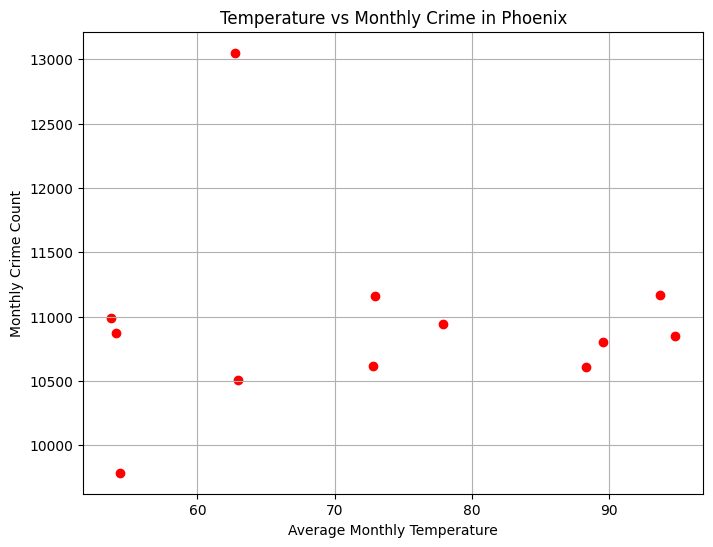

In [18]:
plt.figure(figsize=(8,6))
plt.scatter(merged["temperature"], merged["crime_count"], color='red')
plt.xlabel("Average Monthly Temperature")
plt.ylabel("Monthly Crime Count")
plt.title("Temperature vs Monthly Crime in Phoenix")
plt.grid(True)
plt.show()

I wanted to show the crime count and temperature per month so I made a traditional bar chart graphing the crime count per month. Then I made it into a dual axis chart to add in the temperature averages per month.

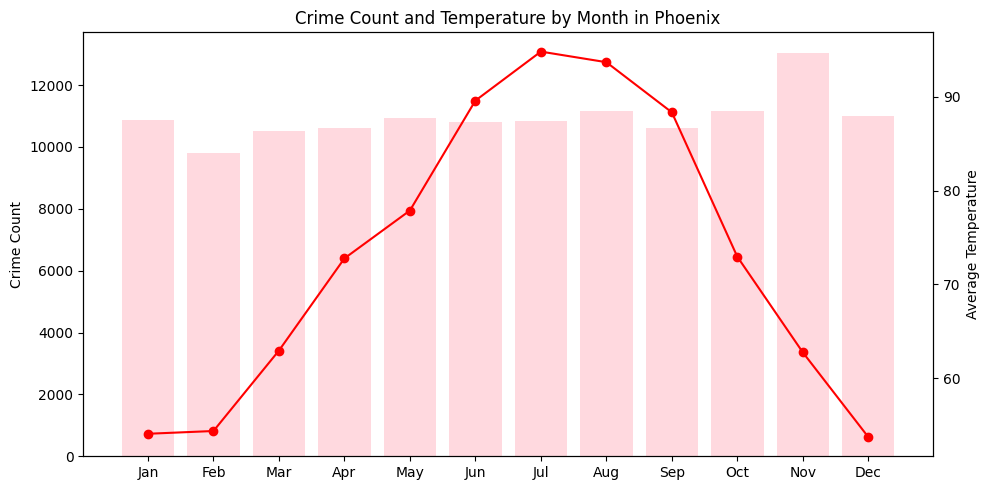

In [24]:
merged_sorted = merged.sort_values("month_num")
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.bar(merged_sorted["month_name"], merged_sorted["crime_count"],
        color="pink", alpha=0.6, label="Crime Count")
ax1.set_ylabel("Crime Count")
ax2 = ax1.twinx()
ax2.plot(merged_sorted["month_name"], merged_sorted["temperature"],
         color="red", marker="o", label="Temperature")
ax2.set_ylabel("Average Temperature")
plt.title("Crime Count and Temperature by Month in Phoenix")
plt.tight_layout()
plt.show()

In [31]:
merged[["temperature", "crime_count"]].corr()


,temperature,crime_count
temperature,1.0000,0.0007
crime_count,0.0007,1.0000


In this final code cell I wanted to see if there was any relationship between crime and the other aspects of the weather dataset. In which i had to import another package to create a heatmap to see see how strongly these variables correlate with one another.

In [22]:
corr_cols = ["crime_count", "temperature", "humidity", "dewPoint", "pressure"]
corr_matrix = merged[corr_cols].corr()
corr_matrix

,crime_count,temperature,humidity,dewPoint,pressure
crime_count,1.000000,0.000700,-0.070601,-0.042021,0.035727
temperature,0.000700,1.000000,-0.831708,0.770176,-0.943154
humidity,-0.070601,-0.831708,1.000000,-0.296884,0.908544
dewPoint,-0.042021,0.770176,-0.296884,1.000000,-0.607343
pressure,0.035727,-0.943154,0.908544,-0.607343,1.000000


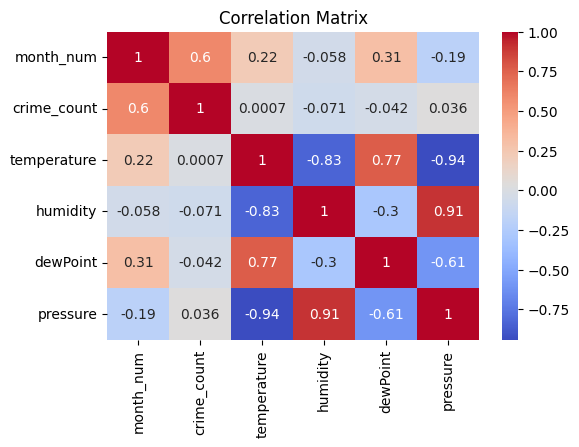

In [23]:
import seaborn as sns
plt.figure(figsize=(6,4))
sns.heatmap(merged.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()